<a href="https://colab.research.google.com/github/SAhmad75/Logo-Classification-using-Transfer-Learning-with-ResNet152-on-Flickr-Logos-27-Dataset/blob/main/Printful_Classification_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**REQUIREMENTS**

In [ ]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [ ]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

2.1.0+cu121
False


In [ ]:
%matplotlib inline
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader

In [ ]:
import urllib.request
import os
import zipfile
import shutil
from pathlib import Path
import tarfile
from sklearn.model_selection import train_test_split

**DOWNLOAD DATASET**

In [ ]:
import requests
import os

def download_file(url, destination):
    response = requests.get(url, stream=True)
    with open(destination, 'wb') as file:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                file.write(chunk)

# URL of the file to download
file_url = "http://image.ntua.gr/iva/datasets/flickr_logos/flickr_logos_27_dataset.tar.gz"

# Local destination path to save the file
destination_path = "flickr_logos_27_dataset.tar.gz"

# Download the file
download_file(file_url, destination_path)

print(f"File downloaded to: {os.path.abspath(destination_path)}")


File downloaded to: /content/flickr_logos_27_dataset.tar.gz


**DATA EXTRACTION**

In [ ]:
import tarfile
import os

def extract_tar_gz(archive_path, extract_path):
    with tarfile.open(archive_path, 'r:gz') as tar:
        tar.extractall(extract_path)

# File paths
archive_path = "flickr_logos_27_dataset.tar.gz"
extract_path = "extracted_data"

# Create the extraction directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Extract the files
extract_tar_gz(archive_path, extract_path)

print(f"Files extracted to: {os.path.abspath(extract_path)}")


Files extracted to: /content/extracted_data


**IMAGES DOWNLOADED USING URL**

In [ ]:
import os
import requests
import time

# Directory to save images
dir_path = "/content/drive/MyDrive/flickr_logos_27_dataset_images"

# Path to the text file containing image URLs
url_file_path = "/content/extracted_data/flickr_logos_27_dataset/flickr_logos_27_dataset_distractor_set_urls.txt"

# Create directory if it doesn't exist
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

# Read the URLs from the text file
with open(url_file_path, 'r') as file:
    url_list = file.read().splitlines()

# Download and save each image
for url in url_list:
    for i in range(5):  # Retry 5 times
        try:
            response = requests.get(url, timeout=5)  # Set a timeout
            file_name = os.path.join(dir_path, url.split("/")[-1])

            with open(file_name, 'wb') as file:
                file.write(response.content)
            break  # If successful, move on to the next image
        except requests.exceptions.RequestException as e:
            print(f"Error downloading {url}: {e}")
            time.sleep(1)  # Wait for a second before retrying


In [ ]:
import os
import shutil

source_directory = '/content/drive/MyDrive/flickr_logos_27_dataset_images/flickr_logos_27_dataset_images'
destination_directory = '/content/drive/MyDrive/flickr_logos_27_dataset_images'

# Get the list of all files in the source directory
files = os.listdir(source_directory)

# Iterate through each file and move it to the destination directory
for file in files:
    source_path = os.path.join(source_directory, file)
    destination_path = os.path.join(destination_directory, file)
    shutil.move(source_path, destination_path)

print("All images moved successfully.")


All images moved successfully.


**TRAIN DATASET/ IMAGES EXTRACTED FROM TAR**

In [ ]:
import tarfile
import os

def extract_images(archive_path, extract_path):
    with tarfile.open(archive_path, 'r:gz') as tar:
        tar.extractall(extract_path)

# File paths
archive_path = "/content/extracted_data/flickr_logos_27_dataset/flickr_logos_27_dataset_images.tar.gz"
extract_path = "/content/drive/MyDrive/flickr_logos_27_dataset_images/"

# Create the extraction directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Extract the images
extract_images(archive_path, extract_path)

print(f"Images extracted to: {os.path.abspath(extract_path)}")


Images extracted to: /content/drive/MyDrive/flickr_logos_27_dataset_images


In [ ]:
import os

def count_files_in_directory(directory_path):
    try:
        # Get the list of files in the directory
        files_list = os.listdir(directory_path)

        # Count the number of files
        num_files = len([f for f in files_list if os.path.isfile(os.path.join(directory_path, f))])

        return num_files

    except FileNotFoundError:
        print(f"Directory '{directory_path}' not found.")
        return None

# Example usage
directory_path = '/content/drive/MyDrive/Cropped_Images/'
total_files = count_files_in_directory(directory_path)

if total_files is not None:
    print(f'Total number of files in directory "{directory_path}": {total_files}')


Total number of files in directory "/content/drive/MyDrive/Cropped_Images/": 808


**CROP LOGOS FROM IMAGES**

In [ ]:
from PIL import Image
import os
import shutil
# Read the annotations file and create a dictionary mapping image filenames to their annotations
annotations_dict = {}
annotations_path = "/content/extracted_data/flickr_logos_27_dataset/flickr_logos_27_dataset_training_set_annotation.txt"
with open(annotations_path, 'r') as annotations_file:
    for line in annotations_file:
        parts = line.split()
        if len(parts) == 7:
            image_filename, brand, _, x1, y1, x2, y2 = parts
            annotations_dict[image_filename] = (brand, int(x1), int(y1), int(x2), int(y2))
def extract_logo_images(annotations_dict, source_dir, destination_dir):
    for image_filename, annotation in annotations_dict.items():
        brand, x1, y1, x2, y2 = annotation

        source_path = os.path.join(source_dir, image_filename)
        destination_path = os.path.join(destination_dir, f"{image_filename}")

        # Open the image
        img = Image.open(source_path)

        # Check if the cropping coordinates are valid
        if 0 <= x1 < x2 <= img.width and 0 <= y1 < y2 <= img.height:
            # Crop the image using the bounding box coordinates
            logo_img = img.crop((x1, y1, x2, y2))

            # Check if the cropped image is not empty
            if logo_img.size[0] > 0 and logo_img.size[1] > 0:
                # Save the cropped logo image
                logo_img.save(destination_path)
                print(f"Logo image saved: {destination_path}")
            else:
                print(f"Skipping {image_filename} as the cropped image is empty.")
        else:
            print(f"Invalid bounding box coordinates for {image_filename}. Skipping.")

# Set the source and destination directories
source_dir = "/content/drive/MyDrive/flickr_logos_27_dataset_images"
destination_dir = "/content/drive/MyDrive/Cropped_Images"

# Call the function to extract logo images
extract_logo_images(annotations_dict, source_dir, destination_dir)


Logo image saved: /content/drive/MyDrive/Cropped_Images/144503924.jpg
Logo image saved: /content/drive/MyDrive/Cropped_Images/2451569770.jpg
Logo image saved: /content/drive/MyDrive/Cropped_Images/390321909.jpg
Logo image saved: /content/drive/MyDrive/Cropped_Images/4761260517.jpg
Logo image saved: /content/drive/MyDrive/Cropped_Images/4763210295.jpg
Logo image saved: /content/drive/MyDrive/Cropped_Images/1230939811.jpg
Logo image saved: /content/drive/MyDrive/Cropped_Images/2550056374.jpg
Logo image saved: /content/drive/MyDrive/Cropped_Images/3294282629.jpg
Logo image saved: /content/drive/MyDrive/Cropped_Images/4061203382.jpg
Logo image saved: /content/drive/MyDrive/Cropped_Images/4499338915.jpg
Logo image saved: /content/drive/MyDrive/Cropped_Images/2534155497.jpg
Logo image saved: /content/drive/MyDrive/Cropped_Images/3007885565.jpg
Logo image saved: /content/drive/MyDrive/Cropped_Images/4336482746.jpg
Logo image saved: /content/drive/MyDrive/Cropped_Images/451265524.jpg
Logo imag

**A single image appears many times in annotations file**

In [ ]:
from collections import defaultdict

# Create a dictionary to count the occurrences of each filename
filename_counts = defaultdict(int)

with open(annotations_path, 'r') as annotations_file:
    for line in annotations_file:
        parts = line.split()
        if len(parts) == 7:
            image_filename = parts[0]
            filename_counts[image_filename] += 1

# Print the filenames that appear more than once
for filename, count in filename_counts.items():
    if count > 1:
        print(f"{filename} appears {count} times in the annotation file.")


144503924.jpg appears 6 times in the annotation file.
2451569770.jpg appears 6 times in the annotation file.
390321909.jpg appears 6 times in the annotation file.
4761260517.jpg appears 6 times in the annotation file.
4763210295.jpg appears 48 times in the annotation file.
1230939811.jpg appears 10 times in the annotation file.
2550056374.jpg appears 5 times in the annotation file.
3294282629.jpg appears 60 times in the annotation file.
4061203382.jpg appears 5 times in the annotation file.
4499338915.jpg appears 5 times in the annotation file.
2534155497.jpg appears 4 times in the annotation file.
3007885565.jpg appears 4 times in the annotation file.
4336482746.jpg appears 4 times in the annotation file.
451265524.jpg appears 4 times in the annotation file.
791925651.jpg appears 4 times in the annotation file.
2403699729.jpg appears 3 times in the annotation file.
3005794070.jpg appears 3 times in the annotation file.
4061203190.jpg appears 3 times in the annotation file.
4605631045.

In [ ]:
print(len(annotations_dict))

809


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Create dataset and apply transforms**

In [ ]:
import os
from sklearn.model_selection import train_test_split
from pathlib import Path
import cv2
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(45),
    transforms.RandomHorizontalFlip(),  # 1. Flip the image horizontally
    transforms.RandomVerticalFlip(),  # 2. Flip the image vertically
    transforms.RandomRotation(30),  # 3. Rotate the image up to 30 degrees
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])  # Normalize images
])
class LogoDataset(Dataset):
    def __init__(self, annotations_dict, images_path, file_list, transform=None, target_size=(224, 224)):
        self.annotations_dict = annotations_dict
        self.images_path = images_path
        self.file_list = file_list
        self.transform = transform
        self.target_size = target_size
        self.class_names = sorted(list(set(brand for brand, _, _, _, _ in self.annotations_dict.values())))
        self.class_to_idx = {class_name: i for i, class_name in enumerate(self.class_names)}

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        filename = self.file_list[idx]
        image_path = os.path.join(self.images_path, filename)
        image = Image.open(image_path)

        annotation = self.annotations_dict.get(filename)
        if annotation:
            brand, x1, y1, x2, y2 = annotation
            brand_idx = self.class_to_idx[brand]

        if self.transform:
            image = self.transform(image)

        return image, brand_idx

In [ ]:
import os
import shutil

def copy_files_with_annotations(file_list, destination_dir, source_dir, annotations_dict):
    for image_filename in file_list:
        destination_path = os.path.join(destination_dir, image_filename)
        source_path = os.path.join(source_dir, image_filename)

        # Check if the file exists before trying to copy it
        if os.path.exists(source_path):
            shutil.copy(source_path, destination_path)
        else:
            print(f"File {source_path} not found. Skipping.")


# # Set the path for annotations
annotations_path = "/content/extracted_data/flickr_logos_27_dataset/flickr_logos_27_dataset_training_set_annotation.txt"
images_path = "/content/drive/MyDrive/Cropped_Images"

In [ ]:
# Define the paths for train, test, and validation sets
train_dir = "/content/dataset_annotations/train"
test_dir = "/content/dataset_annotations/test"
val_dir = "/content/dataset_annotations/validation"

# Create the directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Split the dataset into train, test, and validation sets
train_files, test_val_files = train_test_split(list(annotations_dict.keys()), test_size=0.4, random_state=42)
test_files, val_files = train_test_split(test_val_files, test_size=0.5, random_state=42)

# Move and resize files to their respective directories
copy_files_with_annotations(train_files, train_dir, images_path, annotations_dict)
copy_files_with_annotations(test_files, test_dir, images_path, annotations_dict)
copy_files_with_annotations(val_files, val_dir, images_path, annotations_dict)

# Print the number of files in each set
print(f"Number of training files: {len(os.listdir(train_dir))}")
print(f"Number of testing files: {len(os.listdir(test_dir))}")
print(f"Number of validation files: {len(os.listdir(val_dir))}")

# # Define image transformations
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.RandomRotation(45),
#     transforms.RandomHorizontalFlip(),  # 1. Flip the image horizontally
#     transforms.RandomVerticalFlip(),  # 2. Flip the image vertically
#     transforms.RandomRotation(30),  # 3. Rotate the image up to 30 degrees
#     # Add more transformations as needed
# ])

# Create dataset and dataloaders
train_dataset = LogoDataset(annotations_dict, train_dir, os.listdir(train_dir), transform)
test_dataset = LogoDataset(annotations_dict, test_dir, os.listdir(test_dir), transform)
val_dataset = LogoDataset(annotations_dict, val_dir, os.listdir(val_dir), transform)


train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)


File /content/drive/MyDrive/Cropped_Images/2662264721.jpg not found. Skipping.
Number of training files: 485
Number of testing files: 162
Number of validation files: 161


**CHECK DATA**

In [ ]:
# Get a single batch from the dataloader
dataiter = iter(train_dataloader)
data = next(dataiter)

# Check the type and structure of the batch
print(type(data))
print(len(data))
inputs, labels= data
print("Type of inputs:", type(inputs))
print("Shape of inputs:", inputs.shape)
print("Type of labels:", type(labels))
print(labels)
# print(bbox_coordinates)

<class 'list'>
2
Type of inputs: <class 'torch.Tensor'>
Shape of inputs: torch.Size([32, 3, 224, 224])
Type of labels: <class 'torch.Tensor'>
tensor([23, 10, 22, 12, 11, 14, 10,  8, 26, 20, 12,  6, 26, 22, 13, 21, 17,  3,
         3, 23,  9, 22, 15,  5, 19,  3,  3, 25,  7, 18,  1,  5])


**GET TOTAL NUMBER OF CLASSES**

In [ ]:
# Initialize an empty set to store the unique classes
unique_classes = set()

# Iterate over all batches in the dataloader
for batch in train_dataloader:
    # Extract the labels from the batch
    _, labels, _ = batch

    # Add the unique labels in this batch to the set of unique classes
    unique_classes.update(labels.tolist())

# Print the unique classes
print(unique_classes)


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}


**CLASS NAMES**

In [ ]:
# Get a list of all class names (brands)
class_names = [annotation[0] for annotation in annotations_dict.values()]

# If you want to remove duplicates and sort the class names, you can convert the list to a set and back to a list
class_names = sorted(list(set(class_names)))

print(class_names)


['Adidas', 'Apple', 'BMW', 'Citroen', 'Cocacola', 'DHL', 'Fedex', 'Ferrari', 'Ford', 'Google', 'HP', 'Heineken', 'Intel', 'McDonalds', 'Mini', 'Nbc', 'Nike', 'Pepsi', 'Porsche', 'Puma', 'RedBull', 'Sprite', 'Starbucks', 'Texaco', 'Unicef', 'Vodafone', 'Yahoo']


In [ ]:
print(len(annotations_dict))

809


In [ ]:
print(annotations_dict)

{'144503924.jpg': ('Adidas', 38, 12, 234, 142), '2451569770.jpg': ('Adidas', 242, 208, 413, 331), '390321909.jpg': ('Adidas', 13, 5, 89, 60), '4761260517.jpg': ('Adidas', 43, 122, 358, 354), '4763210295.jpg': ('Adidas', 383, 55, 416, 76), '1230939811.jpg': ('Adidas', 137, 336, 243, 395), '2550056374.jpg': ('Adidas', 18, 2, 488, 278), '3294282629.jpg': ('Adidas', 296, 179, 370, 234), '4061203382.jpg': ('Adidas', 155, 206, 241, 252), '4499338915.jpg': ('Adidas', 72, 20, 392, 210), '2534155497.jpg': ('Adidas', 59, 1, 479, 253), '3007885565.jpg': ('Adidas', 221, 20, 476, 262), '4336482746.jpg': ('Adidas', 16, 194, 246, 351), '451265524.jpg': ('Adidas', 195, 179, 244, 215), '791925651.jpg': ('Adidas', 1, 3, 96, 74), '2403699729.jpg': ('Adidas', 27, 5, 342, 244), '3005794070.jpg': ('Adidas', 233, 9, 474, 242), '4061203190.jpg': ('Adidas', 181, 48, 260, 103), '4605631045.jpg': ('Adidas', 347, 126, 446, 197), '4763207899.jpg': ('Adidas', 405, 5, 446, 31), '145074777.jpg': ('Adidas', 22, 52, 47

**DISPLAY DATA WITH BOUNDING BOXES**

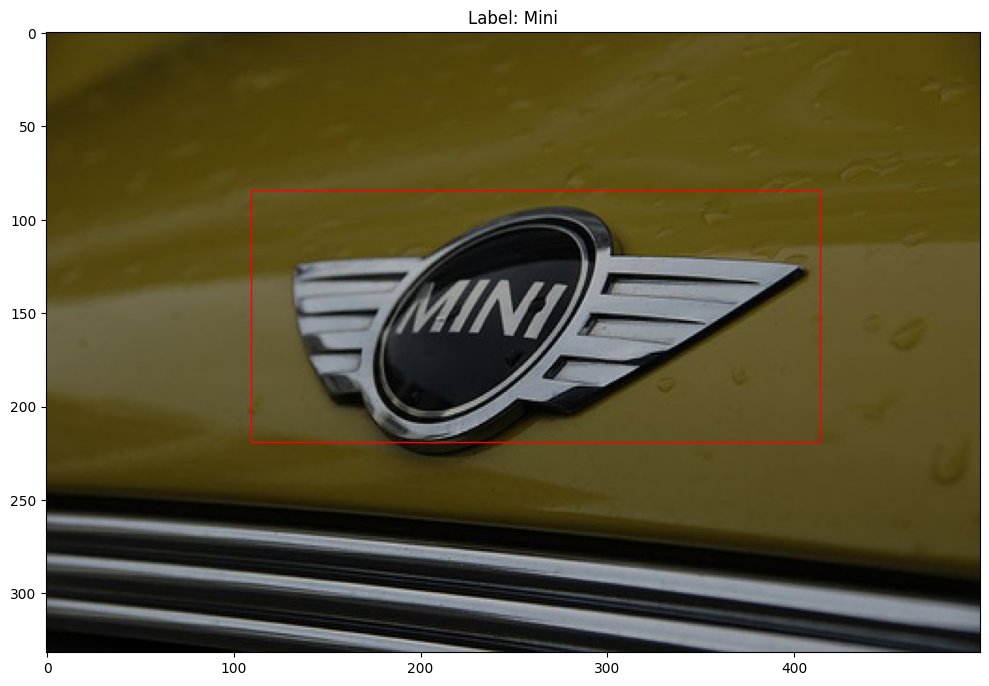

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import os

def display_image_and_label(filename, annotation, images_path):
    fig = plt.figure(figsize=(10, 20))

    img_path = os.path.join(images_path, filename)
    img = mpimg.imread(img_path)

    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(img)
    ax.set_title(f"Label: {annotation[0]}")  # Assuming the label is the first element in the annotation

    # Draw bounding box
    x1, y1, x2, y2 = annotation[1:]  # Assuming the bounding box coordinates are the next four elements in the annotation
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    plt.tight_layout()
    plt.show()

# Use the function
images_path = "/content/dataset_annotations/test/"
filename = "108232417.jpg"
annotation = annotations_dict[filename]  # Assuming annotations_dict is defined
display_image_and_label(filename, annotation, images_path)


**NETWORK CREATION**

In [ ]:
import torch.nn as nn
from torchvision.models import resnet152, ResNet152_Weights

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        base_model =resnet152(ResNet152_Weights.IMAGENET1K_V2)
        num_ftrs = base_model.fc.in_features
        base_model.fc = nn.Identity()  # Remove the last layer
        self.base_model = base_model
        self.classifier = nn.Linear(num_ftrs, 27)  # Classification head

    def forward(self, x):
        x = self.base_model(x)
        return self.classifier(x)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
cnn = CNN()
cnn = cnn.to(device)
cnn

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:17<00:00, 14.1MB/s]


CNN(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

**LOSS FUNCTION AND OPTIMIZER**

In [ ]:
from torch.optim import Adam
criterion_class = nn.CrossEntropyLoss()

# Define your optimizer as usual
optimizer = optim.Adam(cnn.parameters())

**MODEL TRAINING**

In [ ]:
from torchvision import transforms
import torch

def augmentation(image):
    # Define the transformations
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),  # 1. Flip the image horizontally
        transforms.RandomVerticalFlip(),  # 2. Flip the image vertically
        transforms.RandomRotation(30),  # 3. Rotate the image up to 30 degrees
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # 4. Change the color properties
        # transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # 5. Crop and resize
        transforms.RandomPerspective(distortion_scale=0.2, p=0.5),  # 6. Apply perspective transformation
        transforms.RandomAffine(30),  # 7. Apply affine transformation
        transforms.GaussianBlur(3, sigma=(0.1, 2.0))  # 8. Apply Gaussian blur
    ])

    # Apply the transformations and return the augmented image
    return transform(image)


In [ ]:
def train_val(model, criterion_class, optimizer, train_dataloader, val_dataloader, device, num_epochs=25):


    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        model.train()
        running_loss_class = 0.0
        running_corrects = 0

        for batch in train_dataloader:
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            class_outputs = model(inputs)
            _, preds = torch.max(class_outputs, 1)

            loss_class =criterion_class(class_outputs, labels)
            loss = loss_class

            loss.backward()
            optimizer.step()

            running_loss_class += loss_class.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss_class = running_loss_class / len(train_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(train_dataloader.dataset)

        print('Train Classification Loss: {:.4f} Acc.: {:.4f}'.format(epoch_loss_class, epoch_acc*100))

        # Validation phase
        model.eval()
        num_augmentations = 7
        running_loss_class = 0.0
        running_corrects = 0

        for batch in val_dataloader:
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                # Create augmented versions of the input
                aug_inputs = [inputs]
                for _ in range(num_augmentations):  # num_augmentations is the number of augmented versions you want to create
                    aug_inputs.append(augmentation(inputs))  # augmentation is a function that applies random transformations to the images

                # Make predictions for each augmented version and average the results
                class_outputs = []
                for aug_input in aug_inputs:
                    class_output = model(aug_input)
                    class_outputs.append(class_output)
                class_outputs = torch.mean(torch.stack(class_outputs), dim=0)

                _, preds = torch.max(class_outputs, 1)

                # Compute the weighted losses
                loss_class = criterion_class(class_outputs, labels)
                loss = loss_class

                running_loss_class += loss_class.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        epoch_loss_class = running_loss_class / len(val_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(val_dataloader.dataset)

        print('Val Classification Loss: {:.4f} Acc.: {:.4f}'.format(epoch_loss_class, epoch_acc*100))

        # Save the best model weights
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Accuracy: {:.4f}'.format(best_acc*100))

    # Load the best model weights before returning
    model.load_state_dict(best_model_wts)
    return model


In [ ]:
%time
model_cnn = train_val(cnn, criterion_class,  optimizer, train_dataloader, val_dataloader, device)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.48 µs
Epoch 0/24
----------
Train Classification Loss: 2.1658 Acc.: 45.7732
Val Classification Loss: 3.2390 Acc.: 41.6149
Epoch 1/24
----------
Train Classification Loss: 0.9358 Acc.: 75.8763
Val Classification Loss: 2.3120 Acc.: 36.6460
Epoch 2/24
----------
Train Classification Loss: 0.7817 Acc.: 78.9691
Val Classification Loss: 1.3889 Acc.: 64.5963
Epoch 3/24
----------
Train Classification Loss: 0.7298 Acc.: 81.4433
Val Classification Loss: 2.5576 Acc.: 40.3727
Epoch 4/24
----------
Train Classification Loss: 0.5006 Acc.: 84.1237
Val Classification Loss: 1.5079 Acc.: 58.3851
Epoch 5/24
----------
Train Classification Loss: 0.3285 Acc.: 89.4845
Val Classification Loss: 1.3811 Acc.: 63.3540
Epoch 6/24
----------
Train Classification Loss: 0.3936 Acc.: 88.8660
Val Classification Loss: 2.5573 Acc.: 45.3416
Epoch 7/24
----------
Train Classification Loss: 0.2627 Acc.: 94.0206
Val Classification Loss: 2.0330 Acc.: 51.5528
Epoch 8/

**TESTING**

In [ ]:
def test_model(model, criterion_class, test_dataloader, device):
    model.eval()  # Set the model to evaluation mode

    running_loss_class = 0.0
    running_corrects = 0

    # Iterate over the test data
    for batch in test_dataloader:
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        with torch.no_grad():
            class_outputs = model(inputs)
            _, preds = torch.max(class_outputs, 1)

        # Compute loss
        loss_class = criterion_class(class_outputs, labels)
        loss = loss_class

        # Statistics
        running_loss_class += loss_class.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    # Calculate average loss and accuracy
    epoch_loss_class = running_loss_class / len(test_dataloader.dataset)
    epoch_acc = running_corrects.double() / len(test_dataloader.dataset)

    print('Test Classification Loss: {:.4f} Acc.: {:.4f}'.format(epoch_loss_class, epoch_acc*100))


In [ ]:
# Use the function
test_model(model_cnn, criterion_class, test_dataloader, device)

Test Classification Loss: 0.5900 Acc.: 83.9506


In [ ]:
# Get a list of all class names (brands)
class_names = [annotation[0] for annotation in annotations_dict.values()]

# Remove duplicates and sort the class names
class_names = sorted(list(set(class_names)))

# Create a dictionary that maps indices to class names
idx_to_class = {i: class_name for i, class_name in enumerate(class_names)}

print(idx_to_class)


{0: 'Adidas', 1: 'Apple', 2: 'BMW', 3: 'Citroen', 4: 'Cocacola', 5: 'DHL', 6: 'Fedex', 7: 'Ferrari', 8: 'Ford', 9: 'Google', 10: 'HP', 11: 'Heineken', 12: 'Intel', 13: 'McDonalds', 14: 'Mini', 15: 'Nbc', 16: 'Nike', 17: 'Pepsi', 18: 'Porsche', 19: 'Puma', 20: 'RedBull', 21: 'Sprite', 22: 'Starbucks', 23: 'Texaco', 24: 'Unicef', 25: 'Vodafone', 26: 'Yahoo'}


**PREDICTION USING AN IMAGE**

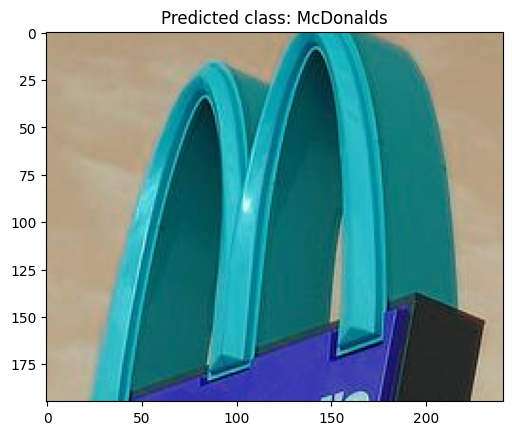

In [ ]:
def predict_and_show_image(image_path, model, idx_to_class):
    # Define the same transforms used on your dataset
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Load and transform the image
    image = Image.open(image_path)
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

    # Make the prediction
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        class_outputs = model(image_tensor)
        _, predicted = torch.max(class_outputs, 1)

    predicted_class = idx_to_class[predicted.item()]

    # Display the image and its predicted class
    fig, ax = plt.subplots(1)
    img = cv2.imread(image_path)
    ax.imshow(img)

    plt.title(f"Predicted class: {predicted_class}")
    plt.show()

# Use the function
image_path = "/content/dataset_annotations/test/2073826793.jpg"
predict_and_show_image(image_path, model_cnn, idx_to_class)
